In [2]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
import imageio
import glob
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from ipywidgets import FloatSlider
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

In [4]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
donald_trump = np.load('ffhq_dataset/latent_representations/donald_trump_01.npy')
hillary_clinton = np.load('ffhq_dataset/latent_representations/hillary_clinton_01.npy')

mx = np.load('latent_codes/max-headshot_01.npy')
mx2 = np.load('latent_codes/test_aligned.npy')
ron = np.load('latent_codes/ron-green-2_01.npy')
zz = np.load('latent_codes/zz-1_01.npy')

brad = np.load('latent_codes/brad_pitt_01.npy')
mbj = np.load('latent_codes/celeb2_aligned.npy')
ll = np.load('latent_codes/celeb3_aligned.npy')
celebs = [brad, mbj, ll]

smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

In [1]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [6]:
def move_and_show_mbj_smile(coeff):
    fig,ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    
    latent_vector = mbj
    direction = smile_direction
    
    new_latent_vector = latent_vector.copy()
    new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
    img = generate_image(new_latent_vector)
    #print(type(img))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [7]:
def mix_two_styles(src_latent, dst_latent):
    
    fig,ax = plt.subplots(1, 3, figsize=(15, 10), dpi=80)
    # Draw the constructed image of the src, the dest, and turn off the labels
    src_img = generate_image(src_latent)
    dst_img = generate_image(dst_latent)
    ax[0].imshow(src_img)
    ax[2].imshow(dst_img)
    [x.axis('off') for x in ax]
   
    # Now construct the mixed image
    #print(src_latent.shape)
    src_latent_copy = src_latent.copy()
    src_latent_copy[range(0,4), :] = dst_latent[range(0,4), :]
    src_latent_copy = src_latent_copy.reshape((1, 18, 512))
    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
    mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
    #mix_img = mix_img.squeze()
    #rint(mix_array[0]- src_array)

    ax[1].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))

In [8]:
def mix_with_celeb_styles(src_latent):
    fig, ax =  plt.subplots(len(celebs), 5, figsize=(15, 10), dpi=80)
    src_img = generate_image(src_latent)
    celeb_pics = [generate_image(lat_var) for lat_var in celebs]
    #ax[0][0].axis('off') #I'm sure this can be done better and nicely with numpy
    
#     # Display top row of celeb pics
#     for i in range(1, len(ax[0])):
#         ax[0][i].imshow(celeb_pics[i-1])
#         ax[0][i].axis('off')
    # put source image first in each row

    for row in range(len(ax)):
        ax[row][0].imshow(src_img)
        ax[row][0].axis('off')
        
        src_latent_copy = src_latent.copy()
        src_latent_copy[range(8,18), :] = celebs[row][range(8,18), :]
        src_latent_copy = src_latent_copy.reshape((1, 18, 512))
        
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
        mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
        
        ax[row][1].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))
        ax[row][1].axis('off')
        
        src_latent_copy = src_latent.copy()
        src_latent_copy[range(4,8), :] = celebs[row][range(4,8), :]
        src_latent_copy = src_latent_copy.reshape((1, 18, 512))
        
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
        mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
        
        ax[row][2].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))
        ax[row][2].axis('off')
        
        src_latent_copy = src_latent.copy()
        src_latent_copy[range(0,4), :] = celebs[row][range(0,4), :]
        src_latent_copy = src_latent_copy.reshape((1, 18, 512))
        
        fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
        mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
        
        ax[row][3].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))
        ax[row][3].axis('off')
        
        ax[row][4].imshow(celeb_pics[row])
        ax[row][4].axis('off')
        
#         for col in range(1, 4):
#             #now generate image
#             ax[row][col].imshow(PIL.)
        
        
#     # Display src_img on 2nd row
#     ax[1][0].imshow(src_img)
#     ax[1][0].axis('off')
    
#     for i, celeb_var in enumerate(celebs):
#         src_latent_copy = src_latent.copy()
#         src_latent_copy[range(0,4), :] = celeb_var[range(0,4), :]
#         src_latent_copy = src_latent_copy.reshape((1, 18, 512))
                
#         fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
#         mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
        
#         ax[1][i+1].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))
#         ax[1][i+1].axis('off')
        

In [9]:
def interactively_mix_two_styles(range_tuple):
    src_latent = mx2
    dst_latent = brad
    
    fig,ax = plt.subplots(1, 3, figsize=(15, 10), dpi=80)
    # Draw the constructed image of the src, the dest, and turn off the labels
    src_img = generate_image(src_latent)
    dst_img = generate_image(dst_latent)
    ax[0].imshow(src_img)
    ax[2].imshow(dst_img)
    [x.axis('off') for x in ax]
   
    # Now construct the mixed image
    #print(src_latent.shape)
    src_latent_copy = src_latent.copy()
    src_latent_copy[range(range_tuple[0],range_tuple[1]), :] = dst_latent[range(range_tuple[0],range_tuple[1]), :]
    src_latent_copy = src_latent_copy.reshape((1, 18, 512))
    
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True) # needed for output_transform - defined in nvidia's code
    mix_array = Gs_network.components.synthesis.run(src_latent_copy, randomize_noise=False, output_transform=fmt)
    #mix_img = mix_img.squeze()
    #rint(mix_array[0]- src_array)

    ax[1].imshow(PIL.Image.fromarray(mix_array[0], 'RGB').resize((256,256)))
    ax[1].set_title('Range %d - %d' % (range_tuple[0], range_tuple[1]))

In [10]:
def draw_truncation_trick(dlatent, psis):
    dlatent_avg = Gs_network.get_var('dlatent_avg') # [component]
    fig,ax = plt.subplots(1, len(psis), figsize=(15, 10), dpi=80)
   
    row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(psis, [-1, 1, 1]) + dlatent_avg
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1) # needed for gs_network
    row_images = Gs_network.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)

    for col, image in enumerate(list(row_images)):
        ax[col].imshow(image)
    [x.axis('off') for x in ax]
    plt.show()

In [11]:
def draw_mbj_truncation_trick(coeff):
    dlatent_avg = Gs_network.get_var('dlatent_avg') # [component]
    fig,ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
   
    row_dlatents = (mbj[np.newaxis] - dlatent_avg) * coeff + dlatent_avg
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1) # needed for gs_network
    row_images = Gs_network.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
    ax.imshow(row_images[0])
    ax.axis('off')
    
    plt.show()

In [8]:
def frange(x, y, jump):
    arr = []
    while x < y:
        arr.append(x)
        x += jump
    return arr

In [8]:
def create_truncation_gif(dlatent):
    dlatent_avg = Gs_network.get_var('dlatent_avg') # [component]

    row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(frange(-1, 1, .05), [-1, 1, 1]) + dlatent_avg
    print(row_dlatents.shape)
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1) # needed for gs_network
    row_images = Gs_network.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)

    for i, image_array in enumerate(list(row_images)):
        im = PIL.Image.fromarray(image_array)
        im.save("gif_files/gif_img_frame_%0.2d.jpeg" % i)

    with imageio.get_writer('truncation1.gif', mode='I') as writer:
        filenames = glob.glob('gif_files/*')
        filenames = sorted(filenames)
        #print(filenames)
        last = -1
        for i,filename in enumerate(filenames):
#             frame = 2*(i**0.5)
#             if round(frame) > round(last):
#                 last = frame
#             else:
#                 continue
            image = imageio.imread(filename)
            writer.append_data(image)
            if i == len(filenames)-1:
                writer.append_data(image)
                
        for i, filename in enumerate(reversed(filenames)):
            image = imageio.imread(filename)
            writer.append_data(image)
            if i == len(filenames)-1:
                writer.append_data(image)


In [11]:
create_truncation_gif(mbj)

(21, 18, 512)


KeyboardInterrupt: 

In [6]:
def create_gif_from_list(dlatents, file_name, duration):
    dlatent_avg = Gs_network.get_var('dlatent_avg') # [component]

    print('Generating frames....')
    for num, dlatent in enumerate(dlatents):
        if num == 0: continue
        set_dlatents = (dlatent[np.newaxis] - dlatents[num-1]) * np.reshape(frange(0, 1, .1), [-1, 1, 1]) + dlatents[num-1]
        synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1) # needed for gs_network
        row_images = Gs_network.components.synthesis.run(set_dlatents, randomize_noise=False, **synthesis_kwargs)
        for i, image_array in enumerate(list(row_images)):
            im = PIL.Image.fromarray(image_array)
            im.save("gif_files/gif_img_frame_{0:02}{1:02}.jpeg".format(num,i))
            
    print('Contsrtucting gif....')
    images = glob.glob('gif_files/*')
    images = sorted(images)
    
    frames = []
    for filename in images:
        frames.append(imageio.imread(filename))

    imageio.mimsave('{}.gif'.format(file_name), frames, format='GIF', duration=duration)
    print('gif created!')

In [1]:
create_gif_from_list([mx,zz,ron,mbj,brad,ll], 'example', .1)

NameError: name 'create_gif_from_list' is not defined

In [14]:
def draw_one_truncation_trick(dlatent, coeff):
    dlatent_avg = Gs_network.get_var('dlatent_avg') # [component]
    fig,ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
   
    row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * coeff + dlatent_avg
    synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1) # needed for gs_network
    row_images = Gs_network.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
    ax.imshow(row_images[0])
#     ax.axis('off')
#     for col, image in enumerate(list(row_images)):
#         ax[col].imshow(image)
#     [x.axis('off') for x in ax]
    plt.show()

In [15]:
def draw_random_face(rndState):
    rnd = np.random.RandomState(rndState)
    latents = rnd.randn(1, Gs_network.input_shape[1])
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    image = Gs_network.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
    img = PIL.Image.fromarray(image[0], 'RGB').resize((256,256))
    
    fig,ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

In [23]:
interact(draw_random_face, rndState=widgets.BoundedIntText(value=7000, 
    min=0,
    max=2**32 - 1,
    description="Random State:",)
    )

interactive(children=(BoundedIntText(value=7000, description='Random State:', max=4294967295), Output()), _dom…

<function __main__.draw_random_face(rndState)>

In [24]:
interact(move_and_show_mbj_smile,coeff=FloatSlider(min=-1, max=1, step=.2, description="Coefficient"))

interactive(children=(FloatSlider(value=0.0, description='Coefficient', max=1.0, min=-1.0, step=0.2), Output()…

<function __main__.move_and_show_mbj_smile(coeff)>

In [25]:
interact(draw_mbj_truncation_trick,coeff=FloatSlider(min=-.7, max=1, step=.2))

interactive(children=(FloatSlider(value=0.0, description='coeff', max=1.0, min=-0.7, step=0.2), Output()), _do…

<function __main__.draw_mbj_truncation_trick(coeff)>

In [26]:
interact_manual(interactively_mix_two_styles, range_tuple=widgets.IntRangeSlider(value=[0, 4], min=0, max=18, step=1, description='Range:',continuous_update=False))

interactive(children=(IntRangeSlider(value=(0, 4), continuous_update=False, description='Range:', max=18), But…

<function __main__.interactively_mix_two_styles(range_tuple)>

![trunc_gif](truncation.gif "example")

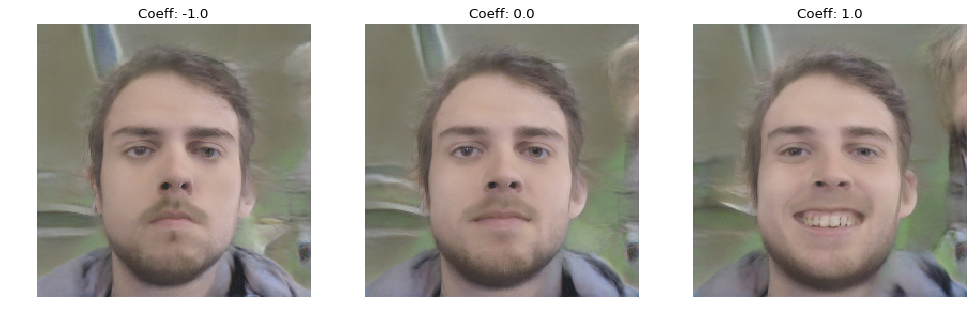

In [51]:
move_and_show(mx2, smile_direction, [-1, 0, 1])

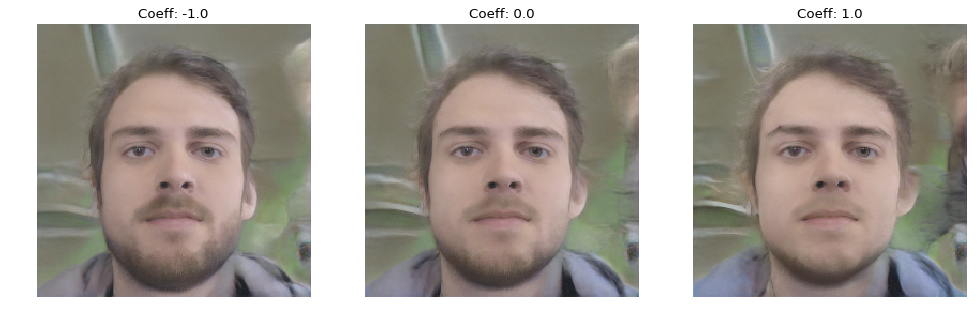

In [40]:
move_and_show(mx2, age_direction, [-1, 0, 1])

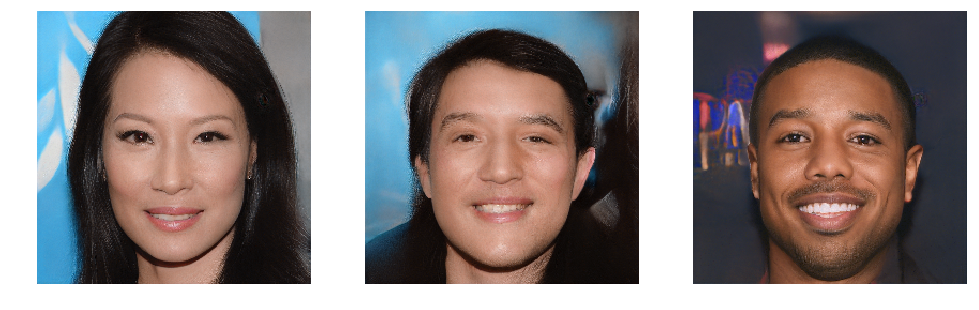

In [60]:
mix_two_styles(ll, mbj)

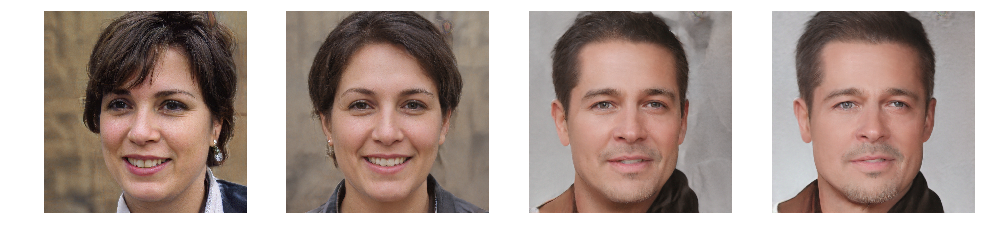

In [27]:
draw_truncation_trick(brad, [-.5, 0, .7, 1])

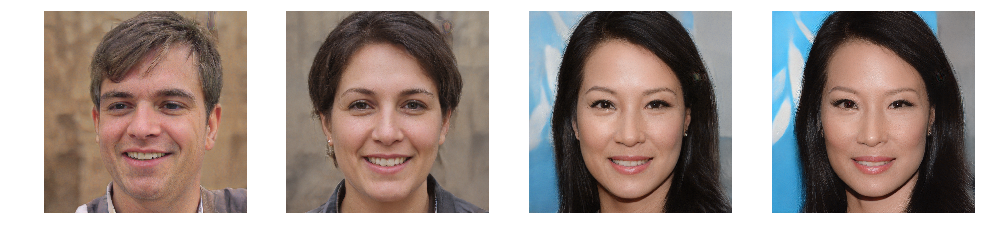

In [28]:
draw_truncation_trick(ll, [-.5, 0, .7, 1])

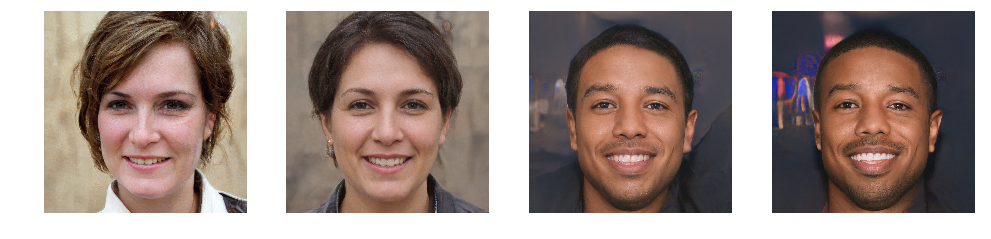

In [91]:
draw_truncation_trick(mbj, [-.5, 0, .7, 1])

In [1]:
mix_with_celeb_styles(mx)

NameError: name 'mix_with_celeb_styles' is not defined